### This notebook generate the line benefits from the operational cost

In [30]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [31]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [32]:
#%% Setting up the path a cases
DirName  = os.getcwd()

# CSV_name =  'OC_fy_(3, 1)h_64e_0.000625lr_0dor_0np_Truero_64bs_0.0ill_TrueMAE'
# CSV_name =  'OC_fy_(3, 2)h_64e_0.0025lr_0dor_0np_Truero_64bs_0.16ill_TrueMAE'
CSV_name =  'OC_fy'

CaseName_Base     = '3-bus'
CaseName_ByStages = '3-bus_'+CSV_name

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [33]:
df_1 = pd.read_csv('Estimated_'+CSV_name+'.csv', index_col=0)

In [34]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [35]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [36]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_2_cac1,Network_Line_In_Node_1_Node_2_cac2,Network_Line_In_Node_1_Node_2_cac3,Network_Line_In_Node_1_Node_3_cac1,Network_Line_In_Node_1_Node_3_cac2,Network_Line_In_Node_1_Node_3_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Unnamed: 11,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
0,0.000310,0.000776,0.001865,0.000896,0.001792,0.003584,0.000002,0.000318,0.001161,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000310,0.000685,0.001774,0.000896,0.001792,0.003584,-0.000055,0.000227,0.001065,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000310,0.000620,0.001669,0.000896,0.001792,0.003584,-0.000055,0.000122,0.000976,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000310,0.000620,0.001549,0.000896,0.001792,0.003584,-0.000055,0.000002,0.000858,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000316,0.000630,0.001446,0.000772,0.001668,0.003460,-0.000178,-0.000233,0.000351,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [38]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_2_cac1,Network_Line_In_Node_1_Node_2_cac2,Network_Line_In_Node_1_Node_2_cac3,Network_Line_In_Node_1_Node_3_cac1,Network_Line_In_Node_1_Node_3_cac2,Network_Line_In_Node_1_Node_3_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3,Unnamed: 11,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40
LoadLevel,,,,,,,,,,,,,,,,,,,,,
01-01 00:00:00+01:00,0.000310,0.000776,0.001865,0.000896,0.001792,0.003584,0.000002,0.000318,0.001161,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01-01 01:00:00+01:00,0.000310,0.000685,0.001774,0.000896,0.001792,0.003584,-0.000055,0.000227,0.001065,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01-01 02:00:00+01:00,0.000310,0.000620,0.001669,0.000896,0.001792,0.003584,-0.000055,0.000122,0.000976,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01-01 03:00:00+01:00,0.000310,0.000620,0.001549,0.000896,0.001792,0.003584,-0.000055,0.000002,0.000858,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01-01 04:00:00+01:00,0.000316,0.000630,0.001446,0.000772,0.001668,0.003460,-0.000178,-0.000233,0.000351,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
ddf_1 = diff_df_1.stack()

In [40]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [41]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [42]:
ddf_1.head()

Value
LoadLevel            Execution                                   
01-01 00:00:00+01:00 Network_Line_In_Node_1_Node_2_cac1  0.000310
                     Network_Line_In_Node_1_Node_2_cac2  0.000776
                     Network_Line_In_Node_1_Node_2_cac3  0.001865
                     Network_Line_In_Node_1_Node_3_cac1  0.000896
                     Network_Line_In_Node_1_Node_3_cac2  0.001792

In [43]:
ddf_1 = ddf_1.reset_index()

In [44]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [45]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [46]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
78619,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.001520,1900-12-30 23:00:00
78620,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac3,0.003311,1900-12-30 23:00:00
78621,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000315,1900-12-30 23:00:00
78622,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000631,1900-12-30 23:00:00
78623,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac3,0.001702,1900-12-30 23:00:00


#### Getting day of year and month

In [47]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [48]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac1,0.000310,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac2,0.000776,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac3,0.001865,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_3_cac1,0.000896,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.001792,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [49]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [50]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
78619,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.001520,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_1_Node_3_cac2_23
78620,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac3,0.003311,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_1_Node_3_cac3_23
78621,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000315,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac1_23
78622,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000631,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac2_23
78623,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac3,0.001702,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac3_23


In [51]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [52]:
table.tail()

Variable   Network_Line_In_Node_1_Node_2_cac1_0  \
Month Day                                         
12    360                              0.000317   
      361                              0.000314   
      362                              0.000531   
      363                              0.000534   
      364                              0.000310   

Variable   Network_Line_In_Node_1_Node_2_cac1_1  \
Month Day                                         
12    360                              0.000316   
      361                              0.000314   
      362                              0.000531   
      363                              0.000533   
      364                              0.000310   

Variable   Network_Line_In_Node_1_Node_2_cac1_10  \
Month Day                                          
12    360                               0.000310   
      361                               0.000310   
      362                               0.000544   
      363                               0.000310   
      364                               0.000484   

Variable   Network_Line_In_Node_1_Node_2_cac1_11  \
Month Day                                          
12    360                               0.000310   
      361                               0.000544   
      362                               0.000544   
      363                               0.000310   
      364                               0.000544   

Variable   Network_Line_In_Node_1_Node_2_cac1_12  \
Month Day                                          
12    360                               0.000310   
      361                               0.000544   
      362                               0.000544   
      363                               0.000544   
      364                               0.000544   

Variable   Network_Line_In_Node_1_Node_2_cac1_13  \
Month Day                                          
12    360                               0.000310   
      361                               0.000544   
      362                               0.000544   
      363                               0.000544   
      364                               0.000544   

Variable   Network_Line_In_Node_1_Node_2_cac1_14  \
Month Day                                          
12    360                               0.000310   
      361                               0.000544   
      362                               0.000544   
      363                               0.000544   
      364                               0.000544   

Variable   Network_Line_In_Node_1_Node_2_cac1_15  \
Month Day                                          
12    360                               0.000310   
      361                               0.000544   
      362                               0.000544   
      363                               0.000544   
      364                               0.000544   

Variable   Network_Line_In_Node_1_Node_2_cac1_16  \
Month Day                                          
12    360                               0.000322   
      361                               0.000405   
      362                               0.000544   
      363                               0.000375   
      364                               0.000544   

Variable   Network_Line_In_Node_1_Node_2_cac1_17  ...  \
Month Day                                         ...   
12    360                               0.000322  ...   
      361                               0.000386  ...   
      362                               0.000539  ...   
      363                               0.000310  ...   
      364                               0.000537  ...   

Variable   Network_Line_In_Node_2_Node_3_cac3_21  \
Month Day                                          
12    360                              -0.000021   
      361                               0.001039   
      362                               0.001134   
      363                               0.000398   
      364        

In [53]:
table = table.reset_index()

In [54]:
table = table.set_index(['Day'])

In [55]:
table.tail()

Variable,Month,Network_Line_In_Node_1_Node_2_cac1_0,Network_Line_In_Node_1_Node_2_cac1_1,Network_Line_In_Node_1_Node_2_cac1_10,Network_Line_In_Node_1_Node_2_cac1_11,Network_Line_In_Node_1_Node_2_cac1_12,Network_Line_In_Node_1_Node_2_cac1_13,Network_Line_In_Node_1_Node_2_cac1_14,Network_Line_In_Node_1_Node_2_cac1_15,Network_Line_In_Node_1_Node_2_cac1_16,...,Network_Line_In_Node_2_Node_3_cac3_21,Network_Line_In_Node_2_Node_3_cac3_22,Network_Line_In_Node_2_Node_3_cac3_23,Network_Line_In_Node_2_Node_3_cac3_3,Network_Line_In_Node_2_Node_3_cac3_4,Network_Line_In_Node_2_Node_3_cac3_5,Network_Line_In_Node_2_Node_3_cac3_6,Network_Line_In_Node_2_Node_3_cac3_7,Network_Line_In_Node_2_Node_3_cac3_8,Network_Line_In_Node_2_Node_3_cac3_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,0.000317,0.000316,0.000310,0.000310,0.000310,0.000310,0.000310,0.000310,0.000322,...,-0.000021,0.000333,0.000647,0.000497,0.000076,-0.000461,-0.000722,-0.000622,-0.000432,0.000027
361,12,0.000314,0.000314,0.000310,0.000544,0.000544,0.000544,0.000544,0.000544,0.000405,...,0.001039,0.001438,0.001726,0.000560,0.000360,-0.000011,-0.000446,-0.000568,-0.000336,0.000375
362,12,0.000531,0.000531,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,...,0.001134,0.001390,0.001557,0.001711,0.001431,0.001067,0.000712,0.000448,0.000562,0.001115
363,12,0.000534,0.000533,0.000310,0.000310,0.000544,0.000544,0.000544,0.000544,0.000375,...,0.000398,0.000566,0.000627,0.001368,0.000785,0.000237,-0.000107,-0.000149,0.000012,0.000325
364,12,0.000310,0.000310,0.000484,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,...,0.001377,0.001645,0.001702,0.000821,0.000418,-0.000050,-0.000217,-0.000133,0.000182,0.000776


#### Split data table into data X and class labels y

In [56]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [57]:
print(X)
print(y)

[[ 3.101950e-04  3.101950e-04  3.102050e-04 ... -4.157530e-04
  -2.605600e-04  4.857100e-05]
 [ 3.102020e-04  3.102020e-04  3.102070e-04 ... -6.389700e-05
   2.104450e-04  3.581920e-04]
 [ 3.102050e-04  3.102040e-04  3.102040e-04 ... -8.189100e-05
   9.757200e-05  2.101280e-04]
 ...
 [ 5.314070e-04  5.314920e-04  5.444290e-04 ...  4.484430e-04
   5.621240e-04  1.115086e-03]
 [ 5.339280e-04  5.330830e-04  3.102000e-04 ... -1.486350e-04
   1.199100e-05  3.252160e-04]
 [ 3.101970e-04  3.101960e-04  4.837090e-04 ... -1.328560e-04
   1.816170e-04  7.759990e-04]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  

## PCA step by step

#### Standardizing of the data

In [58]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [59]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.07586421 -0.03035021 -0.11892745 ... -0.02154116  0.02285868
  -0.0585568 ]
 [-0.07881099 -0.03113102 -0.12311242 ...  0.06125809 -0.05762001
   0.10236682]
 [-0.08626857 -0.03116528  0.00416165 ... -0.0358765   0.01380705
  -0.06658125]
 ...
 [-0.08333196  0.02210744 -0.0889236  ... -0.13934819  0.0775302
   0.1181739 ]
 [-0.08849597  0.01651484 -0.0572271  ...  0.04140749 -0.10465724
  -0.14123798]
 [-0.09374223  0.01828873 -0.02182033 ...  0.05018013  0.01617161
   0.05534031]]

Eigenvalues 
[9.90881475e+01 5.92855943e+01 1.19851355e+01 1.09439022e+01
 6.49761872e+00 3.90314320e+00 3.32201679e+00 2.36881123e+00
 2.06429089e+00 1.78101896e+00 1.45910615e+00 1.27227073e+00
 1.02532343e+00 9.40929863e-01 8.28715728e-01 7.46428752e-01
 7.11370354e-01 5.77984890e-01 5.28896489e-01 4.62235664e-01
 4.34537091e-01 3.92826866e-01 3.63556082e-01 3.24619097e-01
 3.07306725e-01 2.79583556e-01 2.55806421e-01 2.42094696e-01
 2.30690019e-01 2.19484471e-01 2.04098922e-01 1.753124

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [60]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [61]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
99.08814751867524
59.285594329654764
11.985135543485901
10.943902222623494
6.4976187248336
3.9031432009332523
3.322016791605583
2.368811232727541
2.064290885335632
1.7810189574258202
1.4591061509838859
1.2722707340744706
1.025323427173362
0.9409298632340475
0.8287157277101675
0.7464287517736858
0.7113703541701151
0.5779848900233991
0.5288964888844531
0.46223566378076597
0.43453709140807156
0.392826866448348
0.36355608242522947
0.3246190967709997
0.3073067248749623
0.27958355622734254
0.2558064205830164
0.2420946955782451
0.23069001919177337
0.2194844708012478
0.20409892182693284
0.17531246240102916
0.1587426908066765
0.14594579805445076
0.14381987978462213
0.14226787496975327
0.1356166308731391
0.12686053337034917
0.10882399995992892
0.09845435274631084
0.09506011733333199
0.09362123075978614
0.08772721908491543
0.08516635614897054
0.07818893717804569
0.07692972318019653
0.07287707685061202
0.06946567568697344
0.06731546383231136
0.06522020137540091
0.0

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [62]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [63]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

45.74811450610383 0
73.11974497728903 1
78.653175230501 2
83.70587734030504 3
86.70576999027782 4
88.50781641622761 5
90.04156195875002 6
91.13522099095405 7
92.08828569305116 8
92.91056627092252 9
93.58422257536792 10
94.17161863314803 11
94.64500132044952 12
95.07942025150615 13
95.46203091639065 14
95.8066504179345 15
96.13508376979112 16
96.40193424175706 17
96.64612103645723 18
96.85953112237554 19
97.06015302431533 20


Then

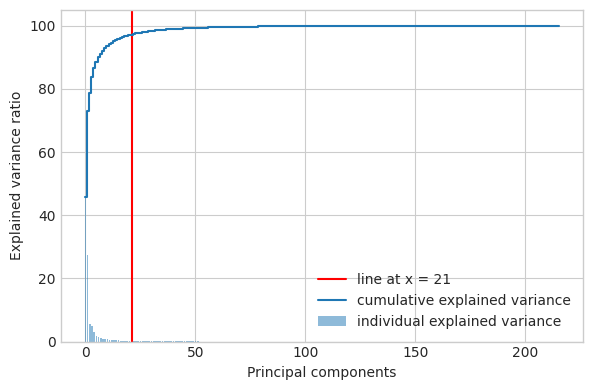

In [64]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [65]:
labels = np.unique(y, axis=0)

In [66]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

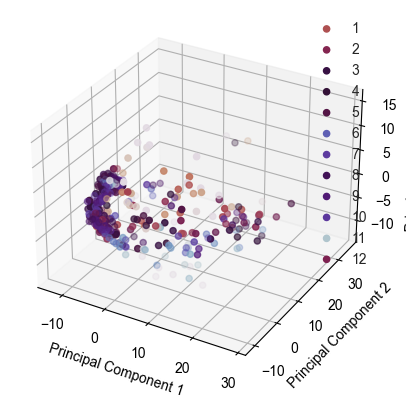

In [67]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

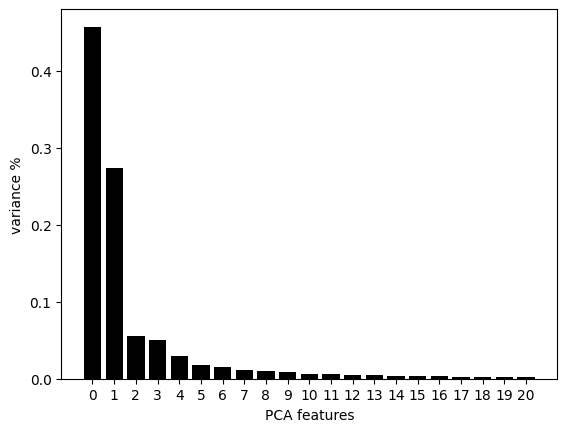

In [68]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [69]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [70]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-1.970189,-8.416605,-1.559328,-4.258652,1.674144,1.080727,-0.085440,1.119444,-1.436622,-0.374805,...,0.762476,0.521460,1.329172,1.478341,-1.091046,0.201444,0.076575,0.203707,0.053533,-0.254523
1,-3.613837,-9.021937,-1.443288,-2.491818,0.976250,-2.337304,1.210741,1.315397,1.423163,-0.711008,...,0.122479,-0.246924,-0.212862,-0.037183,-0.141119,-0.468216,-0.150017,-0.151541,-0.122745,0.191187
2,-1.458334,-9.925888,-2.298591,-2.883180,-0.624351,-1.121833,0.339396,-0.726433,-0.335046,-0.083576,...,0.309176,0.508899,0.185421,0.932455,-0.639216,-0.710479,-0.432777,0.150877,-0.903695,0.217578
3,0.546346,-10.342206,-0.757474,-2.184707,-2.050601,0.405981,0.179287,-1.214576,-1.544457,0.882710,...,1.022821,0.189212,1.612318,1.123996,-1.105440,0.097775,-0.282164,-0.139566,0.092226,-0.330681
4,-3.855060,-9.815978,-0.446608,-1.343009,-0.667342,-3.147259,1.275765,0.623247,0.628152,-0.209772,...,-0.107152,-0.069826,0.323763,-0.266359,0.567034,-0.364935,0.337355,-0.021292,-0.420875,0.259004


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\erik_\miniconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\erik_\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for 

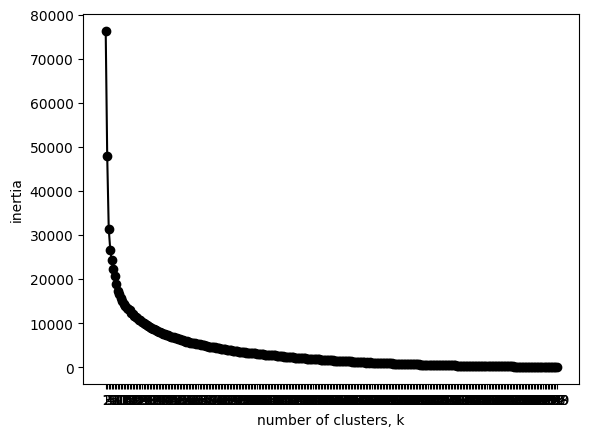

In [71]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [72]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  111


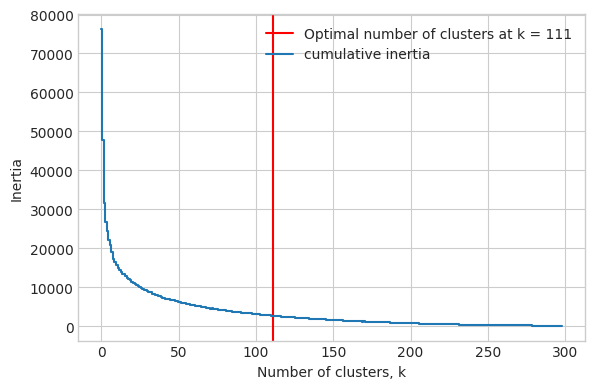

In [73]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [74]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
